In [57]:
# 导入需要使用的库,其中numpy是支持数组和矩阵运算的科学计算库,而matplotlib是绘图库
import numpy as np
import matplotlib.pyplot as plt


class BernoulliBandit:
    """ 伯努利多臂老虎机,输入K表示拉杆个数 """
    def __init__(self, K):
        self.probs = np.random.uniform(size=K)  # 随机生成K个0～1的数,作为拉动每根拉杆的获奖
        # 概率
        self.best_idx = np.argmax(self.probs)  # 获奖概率最大的拉杆
        self.best_prob = self.probs[self.best_idx]  # 最大的获奖概率
        self.K = K  # 奖励最大的拉杆号

    def step(self, k):
        # 当玩家选择了k号拉杆后,根据拉动该老虎机的k号拉杆获得奖励的概率返回1（获奖）或0（未
        # 获奖）
        if np.random.rand() < self.probs[k]:
            return 1
        else:
            return 0


np.random.seed(1)  # 设定随机种子,使实验具有可重复性。np.random.seed()函数用于生成指定随机数
K = 10
bandit_10_arm = BernoulliBandit(K)
print("随机生成了一个%d臂伯努利老虎机" % K)
print("获奖概率最大的拉杆为%d号,其获奖概率为%.4f" %
      (bandit_10_arm.best_idx, bandit_10_arm.best_prob))

# 接下来我们用一个 Solver 基础类来实现上述的多臂老虎机的求解方案。
# 根据前文的算法流程，我们需要实现下列函数功能：根据策略选择动作、根据动作获取奖励、更新期望奖励估值、更新累积懊悔和计数。
# 在下面的 MAB 算法基本框架中，我们将根据策略选择动作、根据动作获取奖励和更新期望奖励估值放在 run_one_step() 函数中，
# 由每个继承 Solver 类的策略具体实现。而更新累积懊悔和计数则直接放在主循环 run() 中。

class Solver:
    """ 多臂老虎机算法基本框架 """
    def __init__(self, bandit):
        self.bandit = bandit
        self.counts = np.zeros(self.bandit.K)  # 每根拉杆的尝试次数
        self.regret = 0.  # 当前步的累积懊悔
        self.actions = []  # 维护一个列表,记录每一步的动作
        self.regrets = []  # 维护一个列表,记录每一步的累积懊悔

    def update_regret(self, k):
        # 计算累积懊悔并保存,k为本次动作选择的拉杆的编号
        self.regret += self.bandit.best_prob - self.bandit.probs[k]
        self.regrets.append(self.regret)

    def run_one_step(self):
        # 返回当前动作选择哪一根拉杆,由每个具体的策略实现
        raise NotImplementedError

    def run(self, num_steps):
        # 运行一定次数,num_steps为总运行次数
        for _ in range(num_steps):
            k = self.run_one_step()
            self.counts[k] += 1
            self.actions.append(k)
            self.update_regret(k)



随机生成了一个10臂伯努利老虎机
获奖概率最大的拉杆为1号,其获奖概率为0.7203


In [62]:
# 完全贪心算法
class EpsilonGreedy (Solver):
    """ epsilon贪婪算法,继承Solver类 """
    def __init__(self, bandit, epsilon=0.01, init_prob=1.0):
        super(EpsilonGreedy, self).__init__(bandit)
        self.epsilon = epsilon
        #初始化拉动所有拉杆的期望奖励估值
        self.estimates = np.array([init_prob] * self.bandit.K)

    def run_one_step(self):
        if np.random.random() < self.epsilon:
            k = np.random.randint(0, self.bandit.K)  # 随机选择一根拉杆
        else:
            k = np.argmax(self.estimates)  # 选择期望奖励估值最大的拉杆
        r = self.bandit.step(k)  # 得到本次动作的奖励
        print(r)
        # epsilon随时间衰减，但有限步数中不会衰减至0
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r -self.estimates[k])   
        return k


# 为了更加直观地展示，可以把每一时间步的累积函数绘制出来。于是我们定义了以下绘图函数，方便之后调用。
def plot_results(solvers, solver_names):
        """生成累积懊悔随时间变化的图像。输入solvers是一个列表,列表中的每个元素是一种特定的策略。
        而solver_names也是一个列表,存储每个策略的名称"""
        for idx, solver in enumerate(solvers):
            time_list = range(len(solver.regrets))
            plt.plot(time_list, solver.regrets, label=solver_names[idx])
        plt.xlabel('Time steps')
        plt.ylabel('Cumulative regrets')
        plt.title('%d-armed bandit' % solvers[0].bandit.K)
        plt.legend()
        plt.show()
        


In [47]:
np.random.seed(1)
epsilon_greedy_solver = EpsilonGreedy(bandit_arm, epsilon=0.01)
epsilon_greedy_solver.run_one_step(5000)
print('epsilon-贪婪算法的累积懊悔为：', epsilon_greedy_solver.regret)
plot_results([epsilon_greedy_solver], ["EpsilonGreedy"])


In [63]:
np.random.seed(1)
epsilon_greedy_solver = EpsilonGreedy(bandit_10_arm, epsilon=0.01)
epsilon_greedy_solver.run(5)
print(epsilon_greedy_solver.counts)
print(epsilon_greedy_solver.regret)
print(epsilon_greedy_solver.actions)
print(epsilon_greedy_solver.estimates)



0
0
1
1
1
[1. 3. 0. 0. 0. 1. 0. 0. 0. 0.]
0.9312883874129444
[0, 5, 1, 1, 1]
[0. 1. 1. 1. 1. 0. 1. 1. 1. 1.]


epsilon-贪婪算法的累积懊悔为： 25.526630933945313


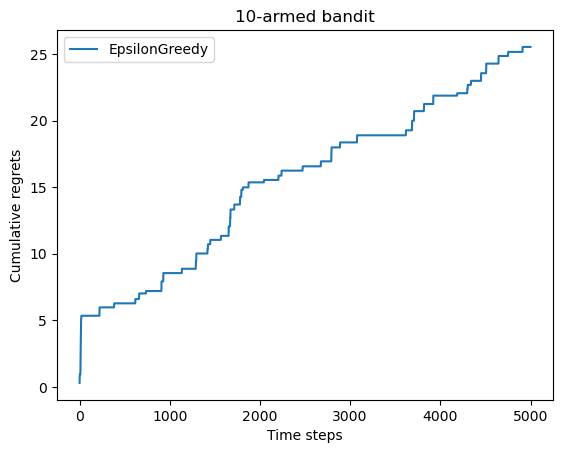

In [48]:
np.random.seed(1)
epsilon_greedy_solver = EpsilonGreedy(bandit_10_arm, epsilon=0.01)
epsilon_greedy_solver.run(5000)
print('epsilon-贪婪算法的累积懊悔为：', epsilon_greedy_solver.regret)
plot_results([epsilon_greedy_solver], ["EpsilonGreedy"])


In [64]:
# 汤普森采样算法
class ThompsonSampling(Solver):
    """ 汤普森采样算法,继承Solver类 """
    def __init__(self, bandit):
        super(ThompsonSampling, self).__init__(bandit)
        self._a = np.ones(self.bandit.K)  # 列表,表示每根拉杆奖励为1的次数
        self._b = np.ones(self.bandit.K)  # 列表,表示每根拉杆奖励为0的次数

    def run_one_step(self):
        samples = np.random.beta(self._a, self._b)  # 按照Beta分布采样一组奖励样本
        k = np.argmax(samples)  # 选出采样奖励最大的拉杆
        r = self.bandit.step(k)

        self._a[k] += r  # 更新Beta分布的第一个参数
        self._b[k] += (1 - r)  # 更新Beta分布的第二个参数
        return k

汤普森采样算法的累积懊悔为： 57.19161964443925


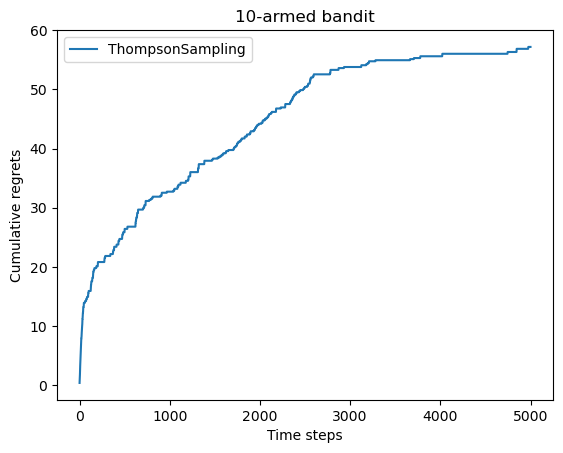

In [65]:
np.random.seed(1)
thompson_sampling_solver = ThompsonSampling(bandit_10_arm)
thompson_sampling_solver.run(5000)
print('汤普森采样算法的累积懊悔为：', thompson_sampling_solver.regret)
plot_results([thompson_sampling_solver], ["ThompsonSampling"])
